In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


# path = "C:/Users/Usuario/projetos/mestrado_amanda/arquivos/"
path = os.path.dirname(os.path.abspath(os.path.dirname(__name__)))
frequencia_atendimento = path+"/arquivos/frequencia_atendimento.xlsx"
quantidade_onibus = path+"/arquivos/viagens.xlsx"

df_frequencia = pd.read_excel(frequencia_atendimento)
df_quantidade = pd.read_excel(quantidade_onibus)

df_frequencia['Linha'] = df_frequencia['Linha'].astype(str)

# print(len(df_frequencia['Linha']))
df_frequencia.sort_values('Frequência')

freq_otima, freq_boa, freq_suficiente, freq_insuficiente = 10, 15, 30, 40

In [4]:
df_quantidade['linha'] = df_quantidade['linha'].astype(str)
df_quantidade['quantidade_veiculos'] = df_quantidade['quantidade_veiculos'].astype(int)
df_quantidade = df_quantidade[['linha','quantidade_veiculos']]
df_quantidade.sort_values('quantidade_veiculos', ascending=False)

,linha,quantidade_veiculos
6,2601,11
11,4601,10
3,1702,8
12,4603,8
2,1701,6
17,5801,6
28,7103,6
18,5802,5
7,2603,5
13,4701,3


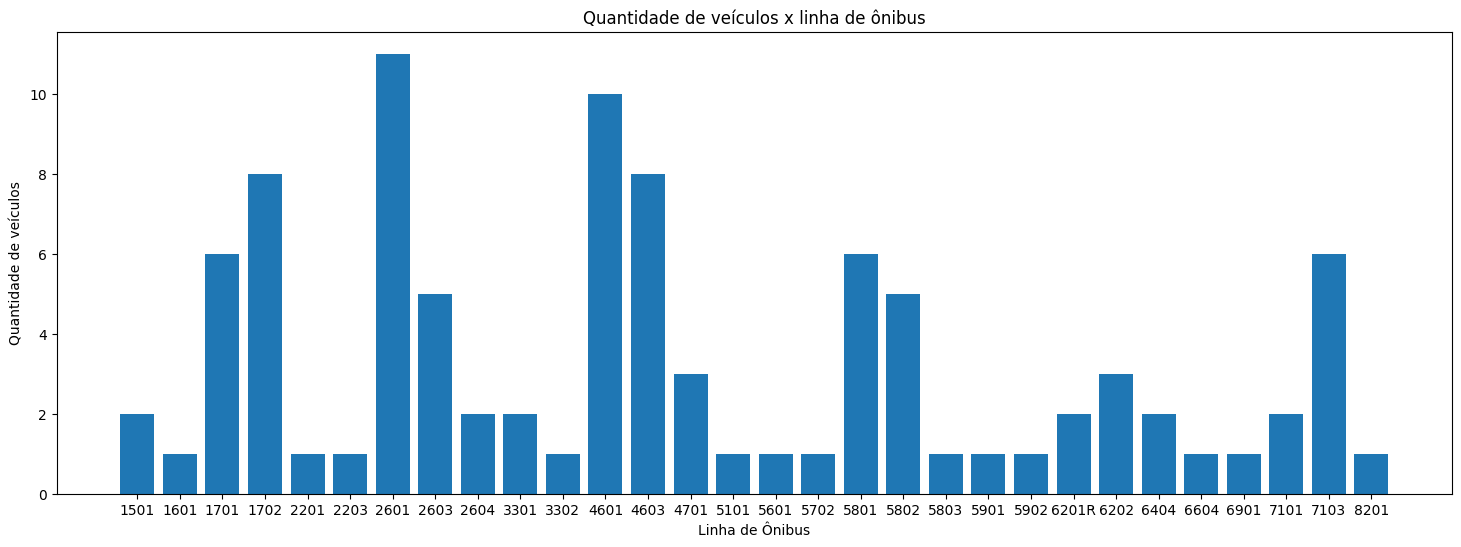

In [5]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.bar(df_quantidade['linha'], df_quantidade['quantidade_veiculos'])

# ax.fill_between(df_frequencia['Linha'], 0, 20, color='red', alpha=0.4, label='Frequência de atendimento boas')
# ax.axhline(freq_otima, color='orange', linestyle='--', label=f'Frequência Ótima: {freq_otima}')
# ax.axhline(freq_boa, color='r', linestyle='--', label=f'Frequência Boa: {freq_boa}')
# ax.axhline(freq_suficiente, color='green', linestyle='--', label=f'Frequência Suficiente: {freq_suficiente}')
# ax.axhline(freq_insuficiente, color='purple', linestyle='--', label=f'Frequência Insuficiente: {freq_insuficiente}')

# ax.fill_between(df_frequencia['Linha'], 0, 50, color='green', alpha=0.4, label='Frequência de atendimento regulares')

# ax.fill_between(df_frequencia['Linha'], 0, 100, color='purple', alpha=0.4, label='Frequência de atendimento ruins')

ax.set_title('Quantidade de veículos x linha de ônibus')
ax.set_xlabel('Linha de Ônibus')
ax.set_ylabel('Quantidade de veículos')
# ax.legend(loc='upper left', prop={'size': 9.5})
# ax.legend(loc='upper left')
# ax.plot(df_frequencia['Frequência'], df_frequencia['Linha'])
plt.show()

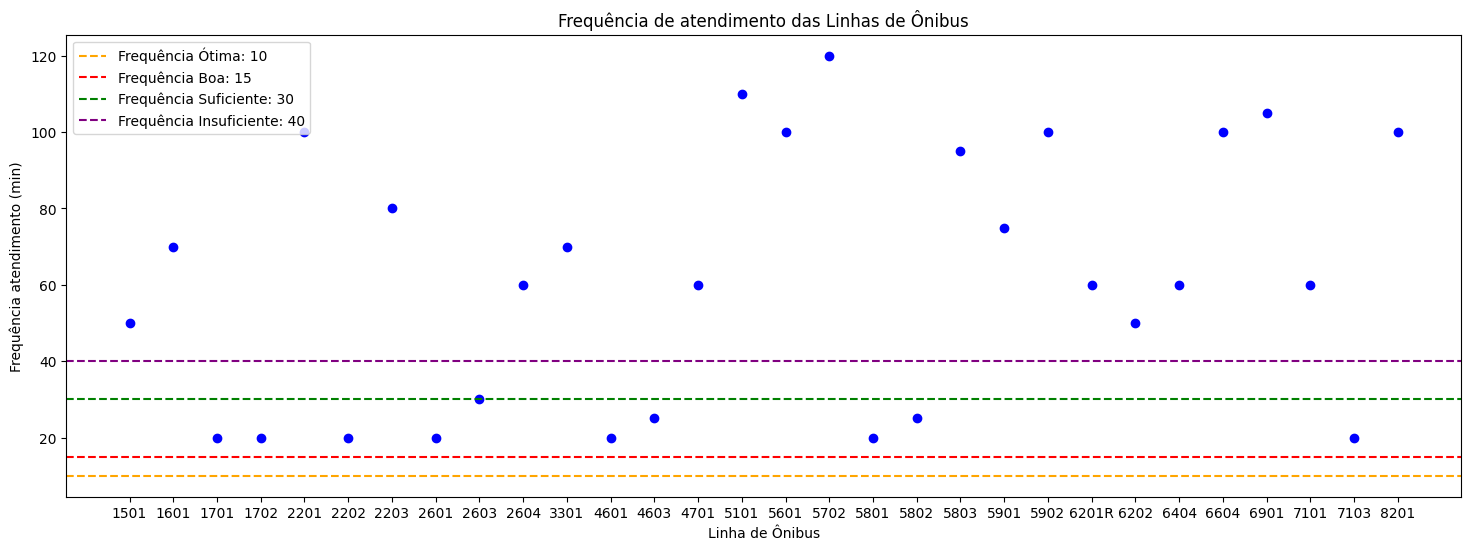

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(df_frequencia['Linha'], df_frequencia['Frequência'], 'bo')

# ax.fill_between(df_frequencia['Linha'], 0, 20, color='red', alpha=0.4, label='Frequência de atendimento boas')
ax.axhline(freq_otima, color='orange', linestyle='--', label=f'Frequência Ótima: {freq_otima}')
ax.axhline(freq_boa, color='r', linestyle='--', label=f'Frequência Boa: {freq_boa}')
ax.axhline(freq_suficiente, color='green', linestyle='--', label=f'Frequência Suficiente: {freq_suficiente}')
ax.axhline(freq_insuficiente, color='purple', linestyle='--', label=f'Frequência Insuficiente: {freq_insuficiente}')

# ax.fill_between(df_frequencia['Linha'], 0, 50, color='green', alpha=0.4, label='Frequência de atendimento regulares')

# ax.fill_between(df_frequencia['Linha'], 0, 100, color='purple', alpha=0.4, label='Frequência de atendimento ruins')

ax.set_title('Frequência de atendimento das Linhas de Ônibus')
ax.set_xlabel('Linha de Ônibus')
ax.set_ylabel('Frequência atendimento (min)')
# ax.legend(loc='upper left', prop={'size': 9.5})
ax.legend(loc='upper left')
# ax.plot(df_frequencia['Frequência'], df_frequencia['Linha'])
plt.show()

In [8]:
ciclo_viagem = path+"/arquivos/planilha_gtfs.xlsx"
df_ciclo = pd.read_excel(ciclo_viagem, sheet_name='operacao')
df_ciclo_correto = df_ciclo[df_ciclo['sentido'] == 'ida']
df_ciclo = df_ciclo_correto[['linha', 'intervalo_minutos', 'ciclo_viagem']]
# df_ciclo['linha'] = df_ciclo['linha'].astype(str)

df_ciclo = df_ciclo.dropna()
df_ciclo['linha'] = df_ciclo['linha'].astype(str)

df_ciclo

,linha,intervalo_minutos,ciclo_viagem
0,1501,50,50.0
2,1601,70,30.0
6,1702,20,40.0
8,2201,100,50.0
10,2203,80,40.0
12,2601,20,15.0
14,2603,30,50.0
16,2604,60,65.0
18,3301,70,50.0
20,3302,105,50.0


In [16]:
media_ciclo = sum(df_ciclo['ciclo_viagem'])/len(df_ciclo['ciclo_viagem'])

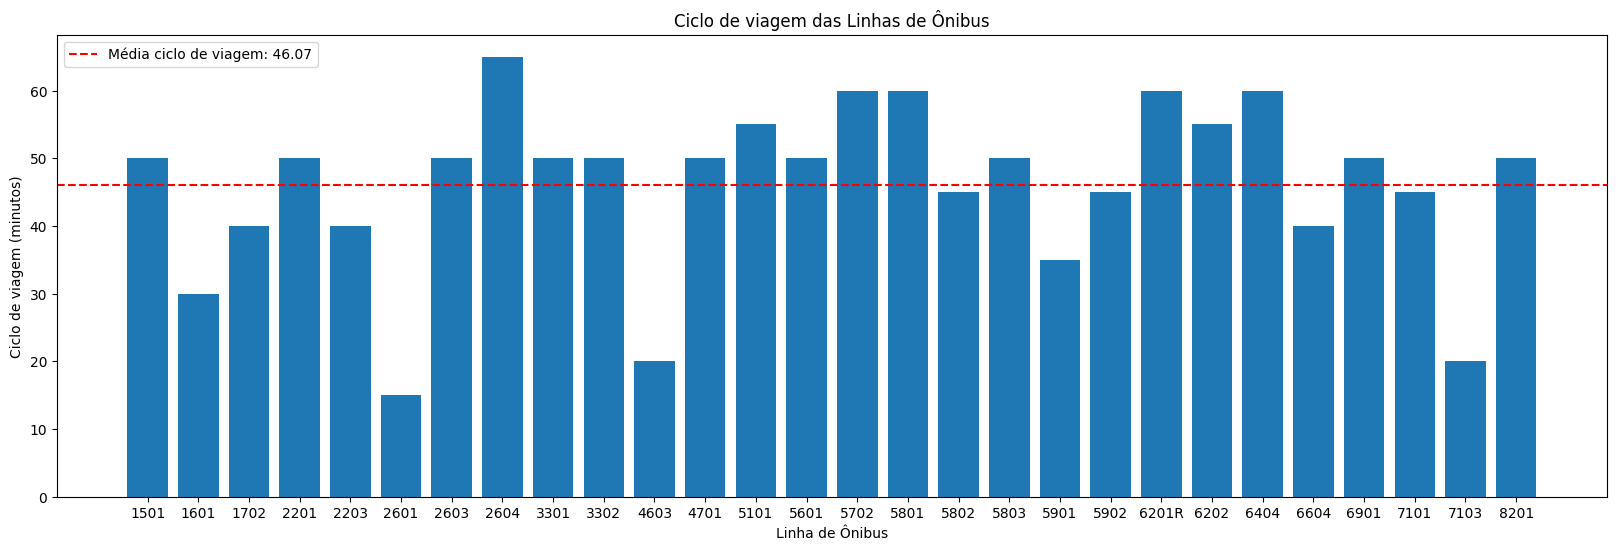

In [19]:

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(df_ciclo['linha'], df_ciclo['ciclo_viagem'])

# ax.fill_between(df_frequencia['Linha'], 0, 20, color='red', alpha=0.4, label='Frequência de atendimento boas')
ax.axhline(media_ciclo, color='red', linestyle='--', label=f'Média ciclo de viagem: {media_ciclo:.2f}')
# ax.axhline(freq_boa, color='r', linestyle='--', label=f'Frequência Boa: {freq_boa}')
# ax.axhline(freq_suficiente, color='green', linestyle='--', label=f'Frequência Suficiente: {freq_suficiente}')
# ax.axhline(freq_insuficiente, color='purple', linestyle='--', label=f'Frequência Insuficiente: {freq_insuficiente}')

# ax.fill_between(df_frequencia['Linha'], 0, 50, color='green', alpha=0.4, label='Frequência de atendimento regulares')

# ax.fill_between(df_frequencia['Linha'], 0, 100, color='purple', alpha=0.4, label='Frequência de atendimento ruins')

ax.set_title('Ciclo de viagem das Linhas de Ônibus')
ax.set_xlabel('Linha de Ônibus')
ax.set_ylabel('Ciclo de viagem (minutos)')
ax.legend(loc='upper left')
# ax.plot(df_frequencia['Frequência'], df_frequencia['Linha'])
plt.show()

In [87]:
indicadores_prioridades = {
    'nomeclatura': ['I4', 'I1', 'I2', 'I3', 'I5', 'I7', 'I6', 'I8', 'I9', 'I10'],
    'prioridade': [0.2269, 0.1526, 0.1121, 0.0997, 0.0992, 0.0954, 0.0831, 0.0756, 0.0277, 0.0277],
    'indicador': ['Pontualidade – cumprir horários', 'Porcentagem das vias pavimentadas', 'Distância entre pontos', 'Integração municipal do sistema de transporte', 'Frequência de atendimento', 'Abrangência da rede – atender a cidade', 'Cumprimento dos itinerários', 'Treinamento e capacitação dos motoristas', 'Existência Sistema de informação pela internet', 'Valor da Tarifa '],
}
df_indicadores_prioridades = pd.DataFrame(indicadores_prioridades)

#Desconsiderar indicadores : I1, I2, I3, I7, I8, I9, I10, 
# Tentar usar indicadores : I4, I5, I6
indicadores_para_usar = ['I4', 'I5', 'I6']
df_indicadores_prioridades

,nomeclatura,prioridade,indicador
0,I4,0.2269,Pontualidade – cumprir horários
1,I1,0.1526,Porcentagem das vias pavimentadas
2,I2,0.1121,Distância entre pontos
3,I3,0.0997,Integração municipal do sistema de transporte
4,I5,0.0992,Frequência de atendimento
5,I7,0.0954,Abrangência da rede – atender a cidade
6,I6,0.0831,Cumprimento dos itinerários
7,I8,0.0756,Treinamento e capacitação dos motoristas
8,I9,0.0277,Existência Sistema de informação pela internet
9,I10,0.0277,Valor da Tarifa


In [88]:
df_indicadores_para_usar = df_indicadores_prioridades[df_indicadores_prioridades['nomeclatura'].isin(indicadores_para_usar)]
# df_indicadores_prioridades.sort_values(by='nomeclatura')
# df_indicadores_prioridades.iloc(3)
df_indicadores_para_usar

,nomeclatura,prioridade,indicador
0,I4,0.2269,Pontualidade – cumprir horários
4,I5,0.0992,Frequência de atendimento
6,I6,0.0831,Cumprimento dos itinerários


In [109]:
pontuacao_indicadores = {
    'linha' : [],
    'I4' : [],
    'I5': [],
    'I6': [],
}

print(len(df_ciclo))

for row in df_ciclo.itertuples():
    pontuacao_indicadores['linha'].append(row.linha)
    if freq_otima <= row.intervalo_minutos < freq_boa:
        pontuacao = 3
    elif freq_boa <= row.intervalo_minutos < freq_suficiente:
        pontuacao = 2
    elif freq_suficiente <= row.intervalo_minutos < freq_insuficiente:
        pontuacao = 1
    else:
        pontuacao = 0
    pontuacao_indicadores['I5'].append(pontuacao)
    # print(row)
pontuacao_indicadores['I4'] = [0] * len(df_ciclo)
pontuacao_indicadores['I6'] = [0] * len(df_ciclo)
df_pontuacao_indicadores = pd.DataFrame(pontuacao_indicadores)

df_pontuacao_indicadores

28


,linha,I4,I5,I6
0,1501,0,0,0
1,1601,0,0,0
2,1702,0,2,0
3,2201,0,0,0
4,2203,0,0,0
5,2601,0,2,0
6,2603,0,1,0
7,2604,0,0,0
8,3301,0,0,0
9,3302,0,0,0


In [106]:
a = [2] * 5
# a.append('2')*3
a

[2, 2, 2, 2, 2]

In [ ]:
# def calculo_indicador():
#     IQt = (pontuacao_indicador * peso_indicador) / desvio_padrao_dos_pesos * numero_pesos